In [2]:
import csv
from collections import defaultdict
from itertools import combinations
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm


# Load data

In [6]:
cat_attrs = ['asd', 'noise', 'motor', 'sleep', 'gi', 'premature', 'hearing', 'vision', 'metabolic', \
             'infections', 'seizures']
disc_attrs = ['gestation', 'verbal']

In [3]:
class Child():
    def __init__(self, data):
        self.id = data[1]
        self.family = data[0]
        self.relatedness = data[2]
        self.sex = data[5]
        self.age = None if data[6]=='' or int(data[6])<0 or int(data[6])>100 else int(data[6])
        self.diagnoses = set(data[7].split(','))
        self.asd = data[8]
        self.premature = data[9]
        self.gestation = 40 if data[10]=='' else int(data[10])
        self.verbal = data[11]
        self.sleep = data[12]
        self.hearing = data[13]
        self.vision = data[14]
        self.noise = data[15]
        self.motor = data[16]
        self.metabolic = data[17]
        self.gi = data[18]
        self.infections = data[19]
        self.seizures = data[20]
        
    def __str__(self):
        return 'Child(id=%s, fam=%s)' % (self.id, self.family)

fam_to_children = defaultdict(list)
with open('../data/kfPedsFileExport_09-12-2022.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    for line in reader:
        child = Child(line)
        fam_to_children[child.family].append(child)

In [4]:
print(set(sum([[x.relatedness for x in children] for children in fam_to_children.values()], [])))

{'full', 'stepmother', 'unrelated', 'stepfather'}


In [5]:
# pull all different types of sibling pairs

class SiblingPair():
    def __init__(self, child1, child2):        
        self.child1 = child1
        self.child2 = child2
        
        
full_sib = []
half_sib_maternal = []
half_sib_paternal = []
unrelated_family = []
unrelated = []
for fam, children in fam_to_children.items():
    for child1, child2 in combinations(children, r=2):
        if child1.relatedness == 'full' and child2.relatedness == 'full':
            full_sib.append(SiblingPair(child1, child2))
        elif (child1.relatedness == 'full' and child2.relatedness == 'stepmother') or \
            (child2.relatedness == 'full' and child1.relatedness == 'stepmother'):
            half_sib_paternal.append(SiblingPair(child1, child2))
        elif (child1.relatedness == 'full' and child2.relatedness == 'stepfather') or \
            (child2.relatedness == 'full' and child1.relatedness == 'stepfather'):
            half_sib_maternal.append(SiblingPair(child1, child2))
        elif (child1.relatedness == 'full' and child2.relatedness == 'unrelated') or \
            (child2.relatedness == 'full' and child1.relatedness == 'unrelated'):
            unrelated_family.append(SiblingPair(child1, child2))
        elif (child1.relatedness == 'stepmother' and child2.relatedness == 'stepmother') or \
            (child2.relatedness == 'stepmother' and child1.relatedness == 'stepmother'):
            pass
        elif (child1.relatedness == 'stepmother' and child2.relatedness == 'stepfather') or \
            (child2.relatedness == 'stepmother' and child1.relatedness == 'stepfather'):
            unrelated_family.append(SiblingPair(child1, child2))
        elif (child1.relatedness == 'stepmother' and child2.relatedness == 'unrelated') or \
            (child2.relatedness == 'stepmother' and child1.relatedness == 'unrelated'):
            pass
        elif (child1.relatedness == 'stepfather' and child2.relatedness == 'stepfather') or \
            (child2.relatedness == 'stepfather' and child1.relatedness == 'stepfather'):
            pass
        elif (child1.relatedness == 'stepfather' and child2.relatedness == 'unrelated') or \
            (child2.relatedness == 'stepfather' and child1.relatedness == 'unrelated'):
            unrelated_family.append(SiblingPair(child1, child2))
        elif (child1.relatedness == 'unrelated' and child2.relatedness == 'unrelated') or \
            (child2.relatedness == 'unrelated' and child1.relatedness == 'unrelated'):
            pass
        
families = list(fam_to_children.keys())
for _ in range(len(full_sib)):
    fam1, fam2 = random.sample(families, 2)
    child1 = random.choice(fam_to_children[fam1])
    child2 = random.choice(fam_to_children[fam2])
    unrelated.append(SiblingPair(child1, child2))

    
            
print('full', len(full_sib))
print('half mat', len(half_sib_maternal))
print('half pat', len(half_sib_paternal))
print('unrelated fam', len(unrelated_family))
print('unrelated', len(unrelated))

full 1415
half mat 239
half pat 72
unrelated fam 92
unrelated 1415


# Categorical Attributes

Let's start by looking at our categorical attributes. We're curious if full siblings are more similar to each other than unrelated children.

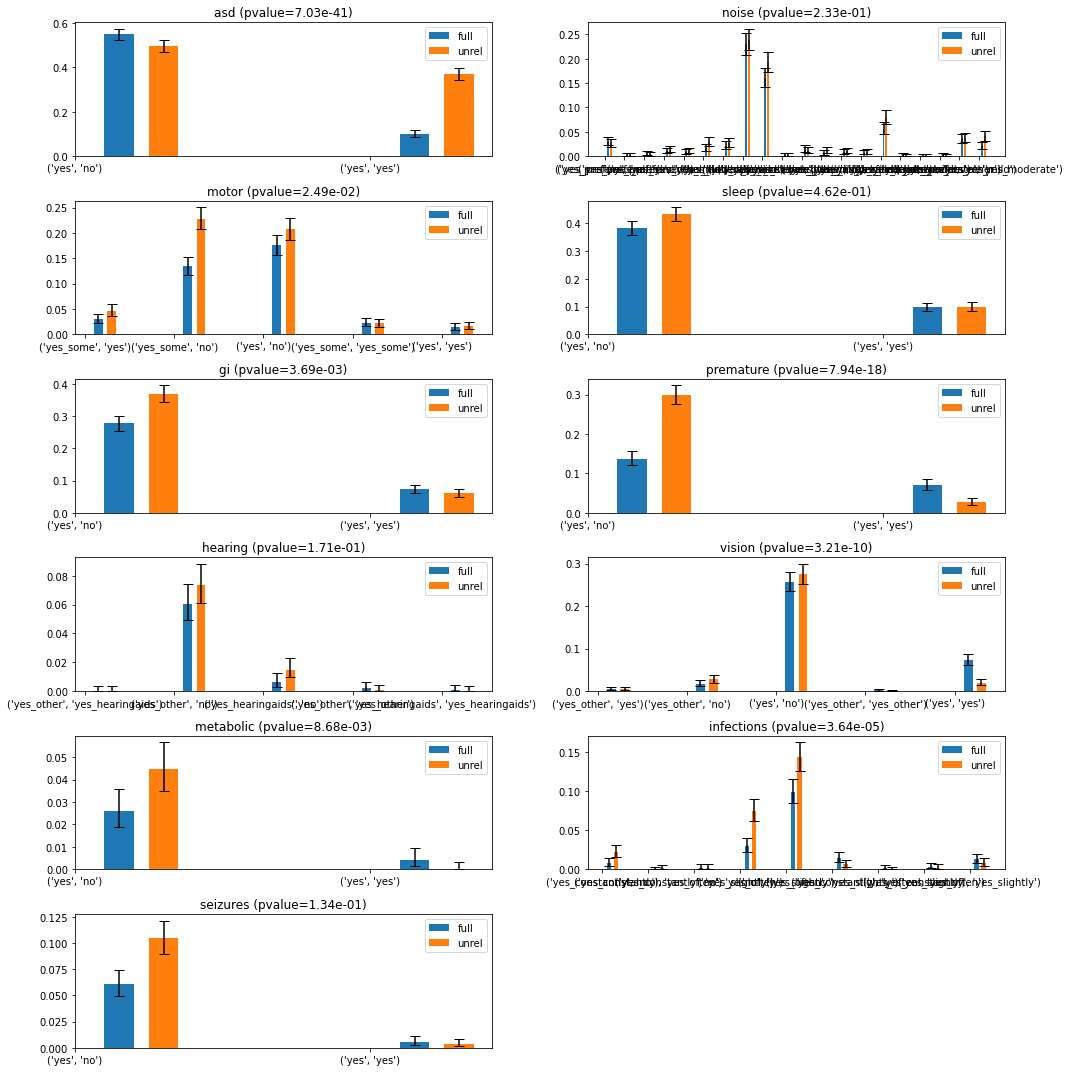

In [15]:
def pull_sibpair_response(sibpairs, attr):
    r = np.zeros((len(options_combos),))
    for sibpair in sibpairs:
        key = (getattr(sibpair.child1, attr), getattr(sibpair.child2, attr))
        if key in response_to_index:
            r[response_to_index[key]] += 1
    return r

def plotbar(r, total, offset=0, label=None):
    p = r/total
    lb, ub = sm.stats.proportion_confint(r, total, alpha=0.05, method='agresti_coull')
    plt.bar(np.arange(len(options_combos))+offset, p, width=0.1, label=label)
    plt.errorbar(np.arange(len(options_combos))+offset, p, 
                 yerr=[p-lb, ub-p], 
                 color='black', linestyle='', capsize=5)

plt.figure(figsize=(15, 15))

for j, attr in enumerate(cat_attrs):
    options = list(set(sum([[getattr(x, attr) for x in children] for children in fam_to_children.values()], [])))

    options_combos = list(combinations(options, 2)) + [(x, x) for x in options]
    options_combos = [x for x in options_combos if x[0] != '' and x[1] != '' and (x[0] != 'no' or x[1] != 'no')]

    response_to_index = dict()
    for i, opt in enumerate(options_combos):
        response_to_index[opt] = i
        response_to_index[(opt[1], opt[0])] = i
        
    response = np.zeros((len(options_combos), 5))
    response[:, 0] = pull_sibpair_response(full_sib, attr)
    response[:, 1] = pull_sibpair_response(half_sib_maternal, attr)
    response[:, 2] = pull_sibpair_response(half_sib_paternal, attr)
    response[:, 3] = pull_sibpair_response(unrelated_family, attr)
    response[:, 4] = pull_sibpair_response(unrelated, attr)
    
    plt.subplot(6, 2, j+1)
    plotbar(response[:, 0], len(full_sib), 0.15, label='full')
    #plotbar(response[:, 1], len(half_sib_maternal), 0.3, label='half mat')
    #plotbar(response[:, 2], len(half_sib_paternal), 0.45, label='half pat')
    #plotbar(response[:, 3], len(unrelated_family), 0.6, label='unrel fam')
    plotbar(response[:, 4], len(unrelated), 0.3, label='unrel')
    plt.xticks(np.arange(len(options_combos)), [str(x) for x in options_combos])

    plt.legend()
    

    c = np.array([response[:, 0], response[:, 4]])
    plt.title('%s (pvalue=%0.2e)' % (attr, stats.chi2_contingency(c[:, np.sum(c, axis=0)>5])[1]))

plt.tight_layout()
plt.show()

In [213]:
# From these plots we can conclude that
# **** ASD very genetic
# **** premature very genetic, not enough half-mat sibpairs to distinguish maternal vs paternal impact
# sleep nothing
# hearing nothing, even when grouping yes and yes-other
# **** vision genetic
# noise nothing, even when grouping yes
# motor nothing, even when grouping yes
# **** metabolic - somewhat genetic, limited by sample size
# **** gi genetic
# **** infections genetic, both with and without grouping yes
# seizures nothing - limited by sample size



# Continuous Attributes

Now we do the same thing with continuous attributes (verbal and gestation).

In [16]:
pull_attr = lambda x: int(x.verbal)
max_diff = 10
#max_diff = 18

In [17]:
options = list(set(sum([[pull_attr(x) for x in children] for children in fam_to_children.values()], [])))
options_combos = np.arange(max_diff)
print(options)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [18]:
response = np.zeros((max_diff, 5))

def pull_sibpair_response(sibpairs, pull_attr):
    r = np.zeros((max_diff,))
    for sibpair in sibpairs:
        r[np.abs(pull_attr(sibpair.child1)-pull_attr(sibpair.child2))] += 1
    return r

response[:, 0] = pull_sibpair_response(full_sib, pull_attr)
response[:, 1] = pull_sibpair_response(half_sib_maternal, pull_attr)
response[:, 2] = pull_sibpair_response(half_sib_paternal, pull_attr)
response[:, 3] = pull_sibpair_response(unrelated_family, pull_attr)
response[:, 4] = pull_sibpair_response(unrelated, pull_attr)
print(response)

[[494.  76.  26.  40. 204.]
 [157.  26.   9.  13. 199.]
 [189.  32.   8.  11. 230.]
 [138.  11.  10.   4. 231.]
 [ 99.  19.   2.   5. 153.]
 [ 70.   4.   1.   4. 130.]
 [ 65.  16.   2.   6.  82.]
 [ 55.  17.   2.   2.  80.]
 [ 57.  17.   5.   5.  43.]
 [ 91.  21.   7.   2.  63.]]


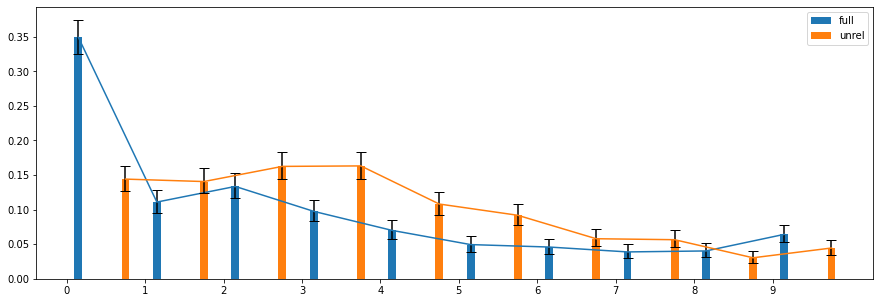

[[494. 157. 189. 138.  99.  70.  65.  55.  57.  91.]
 [204. 199. 230. 231. 153. 130.  82.  80.  43.  63.]]
full sib vs unrelated (196.1110734479606, 2.1634578505933778e-37, 9, array([[349. , 178. , 209.5, 184.5, 126. , 100. ,  73.5,  67.5,  50. ,
         77. ],
       [349. , 178. , 209.5, 184.5, 126. , 100. ,  73.5,  67.5,  50. ,
         77. ]]))
half mat vs unrelated (92.08074166270056, 6.220145926604048e-16, 9, array([[ 40.45949214,  32.5120919 ,  37.85852479,  34.96856106,
         24.85368803,  19.36275695,  14.16082225,  14.01632406,
          8.66989117,  12.13784764],
       [239.54050786, 192.4879081 , 224.14147521, 207.03143894,
        147.14631197, 114.63724305,  83.83917775,  82.98367594,
         51.33010883,  71.86215236]]))
half pat vs unrelated (40.734687683357, 5.58981234667294e-06, 9, array([[ 11.13651648,  10.07128447,  11.52387357,  11.66913248,
          7.50504371,   6.34297243,   4.0672495 ,   3.97041022,
          2.32414257,   3.38937458],
       [218.863483

In [21]:
plt.figure(figsize=(15, 5))
plotbar(response[:, 0], len(full_sib), 0.15, label='full')
plt.plot(np.arange(0, max_diff)+0.15, response[:, 0]/len(full_sib))

#plotbar(response[:, 1], len(half_sib_maternal), 0.3, label='half mat')
#plt.plot(np.arange(0, max_diff)+0.3, response[:, 1]/len(half_sib_maternal))

#plotbar(response[:, 2], len(half_sib_paternal), 0.45, label='half pat')
#plt.plot(np.arange(0, max_diff)+0.45, response[:, 2]/len(half_sib_paternal))

#plotbar(response[:, 3], len(unrelated_family), 0.6, label='unrel fam')
#plt.plot(np.arange(0, max_diff)+0.6, response[:, 3]/len(unrelated_family))

plotbar(response[:, 4], len(unrelated), 0.75, label='unrel')
plt.plot(np.arange(0, max_diff)+0.75, response[:, 4]/len(unrelated))

plt.xticks(np.arange(len(options_combos)), [str(x) for x in options_combos])
    
plt.legend()
plt.show()

c = np.array([response[:, 0], response[:, 4]])
print(c)

print('full sib vs unrelated', stats.chi2_contingency(c[:, np.sum(c, axis=0)>5]))
print('half mat vs unrelated', stats.chi2_contingency([response[:, 1], response[:, 4]]))
print('half pat vs unrelated', stats.chi2_contingency([response[:, 2], response[:, 4]]))

In [20]:
# gestation, highly genetic
# verbal, highly genetic, we see mat half sib signal
